# Creating a Custom Rate

Let's imagine wanting to add a rate that has a temperature form not known to pynucastro.  We can accomplish this by creating a new class derived from `Rate`.

We'll consider a rate of the form:

$$r = r_0 \left (\frac{T}{T_0} \right )^\nu$$

representing a reaction of the form

$$A + B \rightarrow C + D$$

then we expect the $\dot{Y}$ evolution equation for this rate to have the form:

$$\frac{dY(A)}{dt} = -\rho Y(A) Y(B) r_0 \left ( \frac{T}{T_0} \right )^\nu$$

and likewise for the other nuclei.


In [1]:
import pynucastro as pyna

We'll use this to approximate the rate ${}^{14}\mathrm{N}(p, \gamma){}^{15}\mathrm{O}$ around a temperature of
$T = 3\times 10^7~\mathrm{K}$

In [2]:
rl = pyna.ReacLibLibrary()
r = rl.get_rate_by_name("n14(p,g)o15")

We can get the values of $r_0$ and $\nu$ about this temperature from the rate

In [3]:
T0 = 3.e7
nu = r.get_rate_exponent(T0)
r0 = r.eval(T0)
print(r0, nu)

1.416655077954945e-13 15.601859314950396


Now we can write our custom rate.  A few bits are needed in the initialization:

* We need to set the "chapter" to "custom" -- this will be used by `PythonNetwork` to know how to group this rate with the others
* We call the parent `Rate` class's `__init__()` to do all the remaining initialization.

We only write 2 additional methods here:

* `function_string_py()` is used when outputting a `PythonNetwork` to a `.py` file that can be imported and used for integration
* `eval()` is used when evaluating the rate interactively (including when making plots)

In [4]:
class MyRate(pyna.Rate):
    def __init__(self, reactants=None, products=None,
                 r0=1.0, T0=1.0, nu=0):

        # we set the chapter to custom so the network knows how to deal with it
        self.chapter = "custom"
    
        # call the Rate init to do the remaining initialization
        super().__init__(reactants=reactants, products=products)

        self.r0 = r0
        self.T0 = T0
        self.nu = nu

    def function_string_py(self):
        """return a string containing a python function that computes
        the rate"""
        fstring = ""
        fstring += "@numba.njit()\n"
        fstring += f"def {self.fname}(rate_eval, tf):\n"
        fstring += f"    rate_eval.{self.fname} = {self.r0} * (tf.T9 * 1.e9 / {self.T0} )**({self.nu})\n\n"
        return fstring

    def eval(self, T, rhoY=None):
        return self.r0 * (T / self.T0)**self.nu

Now we can create our custom rate

In [5]:
r_custom = MyRate(reactants=[pyna.Nucleus("n14"), pyna.Nucleus("p")],
                  products=[pyna.Nucleus("o15")],
                  r0=r0, T0=T0, nu=nu)

In [6]:
r_custom.fname

'N14_p__O15__generic'

Notice that it can write out the function needed to evaluate this rate in a python module

In [7]:
print(r_custom.function_string_py())

@numba.njit()
def N14_p__O15__generic(rate_eval, tf):
    rate_eval.N14_p__O15__generic = 1.416655077954945e-13 * (tf.T9 * 1.e9 / 30000000.0 )**(15.601859314950396)




## Creating a network with our rate

Now let's create a network that includes this rate.  We'll base it off of the CNO net, but we'll leave out the rate that we are approximating.

In [8]:
rate_names = ["c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15"]
rates = rl.get_rate_by_name(rate_names)

Here we'll add our custom rate to the remaining rates we pulled from ReacLib

In [9]:
pynet = pyna.PythonNetwork(rates=rates+[r_custom])

We can plot this to see how it behaves.  First a low temperature

In [10]:
T = 3.e7
rho = 200
comp = pyna.Composition(pynet.unique_nuclei)
comp.set_solar_like()

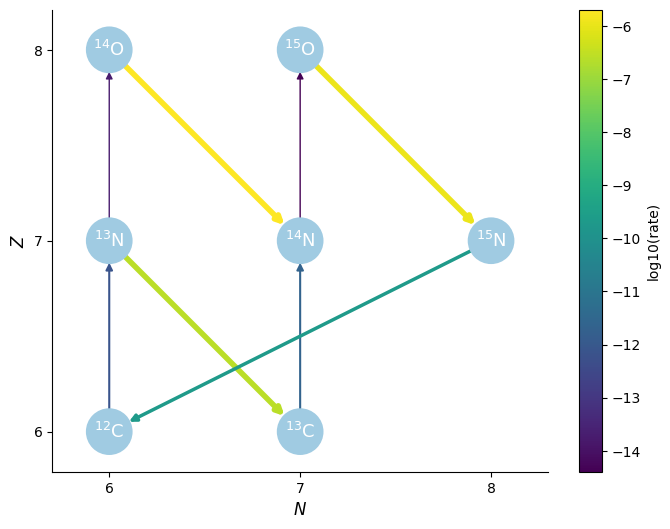

In [11]:
fig = pynet.plot(rho=rho, T=T, comp=comp)

Now a higher temperature

In [12]:
T = 3.e8

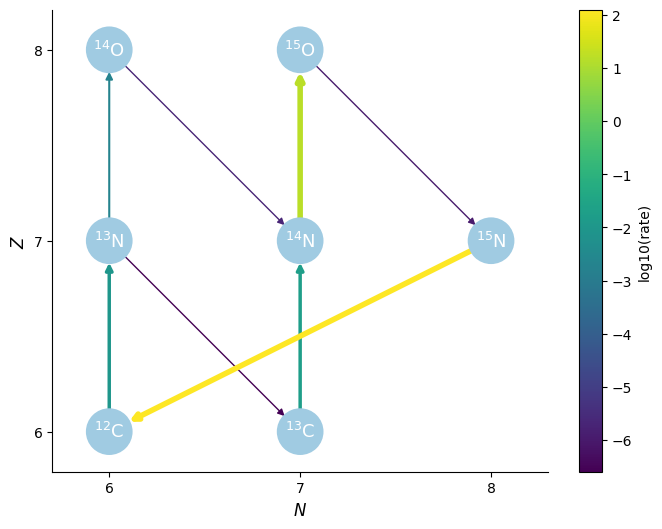

In [13]:
fig = pynet.plot(rho=rho, T=T, comp=comp)

Notice that at the higher temperature, this rate becomes higher than the beta decay to ${}^{13}\mathrm{C}$.

We can also see the values of the ydot terms in the network

In [14]:
pynet.evaluate_ydots(rho, T, comp)

{p: -140.31578946054762,
 He4: 124.10404295119419,
 C12: 124.09500217697241,
 C13: -0.017818574032238365,
 N13: 0.00701794538740977,
 N14: -16.16504349981351,
 N15: -124.1040418689929,
 O14: 0.002020570415053316,
 O15: 16.182863250063768}

Finally, we can see that when the network constructs the `dYdt` term,
when writing out the network (via `pynet.write_network()`), our rate
is included.  For example, for the protons:

In [15]:
print(pynet.full_ydot_string(pyna.Nucleus("p")))

dYdt[jp] = (
   -rho*Y[jp]*Y[jc12]*rate_eval.p_C12__N13
   -rho*Y[jp]*Y[jc13]*rate_eval.p_C13__N14
   -rho*Y[jp]*Y[jn13]*rate_eval.p_N13__O14
   -rho*Y[jp]*Y[jn15]*rate_eval.p_N15__He4_C12
   -rho*Y[jp]*Y[jn14]*rate_eval.N14_p__O15__generic
   )


